In [43]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from collections import Counter
import scipy.stats as stats # for the breakpoints in SAX
from scipy.stats import norm
from dtw import dtw
import os
from scipy import signal
import seaborn as sns
from statsmodels.tsa.stattools import acf

##Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

## TSLEARN
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset

## Custom : code implémenté par nous-même
from Symbol import SYMBOLS
from SFA import *
from ASTRIDE import *
from SAX_transf import *
from distances import MINDIST, TRENDIST
import utils
import warnings 
import sax_clustering

warnings.filterwarnings('ignore')

In [ ]:
ECG200_X_train, ECG200_x_train, ECG200_y_train, ECG200_X_test, ECG200_x_test, ECG200_y_test = utils.generate_data(type="ECG200")
acsf1_X_train, acsf1_x_train, acsf1_y_train, acsf1_X_test, acsf1_x_test, acsf1_y_test = utils.generate_data(type="acsf1")
catsanddogs_X_train, catsanddogs_x_train, catsanddogs_y_train, catsanddogs_X_test, catsanddogs_x_test, catsanddogs_y_test = utils.generate_data(type="catsanddogs")

In [89]:
def k_means_sax(sax, max_iter, num_cluster):
    """
    Implémente l'algorithme K-Means adapté pour des observations sous forme de chaînes.

    Parameters:
    sax (SYMBOLS): comme rendu par SYMBOLS()
    max_iter (int): Nombre maximum d'itérations.
    num_cluster (int): Nombre de clusters à former.

    Returns:
    tuple: Un tuple contenant :
        - Les indices des centres finaux des clusters (list).
        - Les labels des clusters pour chaque observation (np.ndarray de taille (n,)).
        - La distance intra-cluster moyenne (float).
        - La distance inter-cluster moyenne (float).
    """
    data = sax.symbolized_x_train.iloc[1,:]

    # Choix de la mesure de distance
    if sax.method == "TSAX":
        dist = TRENDIST(sax.alphabet_size, sax.train_ts_length, sax.angle_breakpoint_alphabet_size)
    else:
        dist = MINDIST(sax.alphabet_size, sax.train_ts_length)

    # Étape 1 : Initialisation
    num_samples = data.shape[0]  # nombre d'observations
    np.random.seed(42)  # Pour la reproductibilité
    initial_indices = np.random.choice(num_samples, num_cluster, replace=False)
    centroids = initial_indices  # Les centroïdes sont initialisés par des indices

    # Initialiser les labels des clusters (0, 1, ..., num_cluster-1)
    labels = np.zeros(num_samples, dtype=int)

    # Boucle principale de l'algorithme K-Means
    for iteration in range(max_iter):
        # Étape 2 : Assignation des observations aux clusters les plus proches
        for i in range(num_samples):
            distances = []
            for centroid_idx in centroids:
                if sax.method == "TSAX":
                    distances.append(dist.tsax_mindist(data.iloc[i], data.iloc[centroid_idx]))
                else:
                    distances.append(dist.mindist(data.iloc[i], data.iloc[centroid_idx]))
            # Trouver le centroïde le plus proche et assigner l'observation à ce cluster
            labels[i] = np.argmin(distances)

        # Étape 3 : Mise à jour des centroïdes
        new_centroids = []
        for k in range(num_cluster):
            # Extraire les indices des observations appartenant au cluster k
            cluster_indices = np.where(labels == k)[0]
            if len(cluster_indices) > 0:
                # Trouver le point le plus central dans le cluster
                min_distance_sum = float("inf")
                central_index = cluster_indices[0]
                for idx in cluster_indices:
                    # Calculer la somme des distances de ce point à tous les autres du cluster
                    distance_sum = 0
                    for other_idx in cluster_indices:
                        if sax.method == "TSAX":
                            distance_sum += dist.tsax_mindist(data.iloc[idx], data.iloc[other_idx])
                        else:
                            distance_sum += dist.mindist(data.iloc[idx], data.iloc[other_idx])
                    # Mettre à jour le point central si une plus petite somme est trouvée
                    if distance_sum < min_distance_sum:
                        min_distance_sum = distance_sum
                        central_index = idx
                new_centroids.append(central_index)
            else:
                # Si un cluster est vide, réinitialiser son centroïde de manière aléatoire
                new_centroids.append(np.random.choice(num_samples))

        # Vérifier la convergence
        if np.array_equal(centroids, new_centroids):
            print(f"Convergence atteinte après {iteration + 1} itérations.")
            break
        
        # Mettre à jour les centroïdes pour la prochaine itération
        centroids = new_centroids

    # Calcul de la distance intra-cluster moyenne
    intra_cluster_distances = []
    for k in range(num_cluster):
        cluster_indices = np.where(labels == k)[0]
        for idx in cluster_indices:
            if sax.method == "TSAX":
                intra_cluster_distances.append(dist.tsax_mindist(data.iloc[idx], data.iloc[centroids[k]]))
            else:
                intra_cluster_distances.append(dist.mindist(data.iloc[idx], data.iloc[centroids[k]]))
    intra_cluster_mean_distance = np.mean(intra_cluster_distances) if intra_cluster_distances else 0.0

    # Calcul de la distance inter-cluster moyenne
    inter_cluster_distances = []
    for i in range(num_cluster):
        for j in range(i + 1, num_cluster):
            if sax.method == "TSAX":
                inter_cluster_distances.append(
                    dist.tsax_mindist(data.iloc[centroids[i]], data.iloc[centroids[j]])
                )
            else:
                inter_cluster_distances.append(
                    dist.mindist(data.iloc[centroids[i]], data.iloc[centroids[j]])
                )
    inter_cluster_mean_distance = np.mean(inter_cluster_distances) if inter_cluster_distances else 0.0

    return centroids, labels, intra_cluster_mean_distance, inter_cluster_mean_distance

In [83]:
# store the dataframes in a dictionnary
typical_df = {
    "ECG200": (ECG200_X_train, ECG200_X_test),
    "ACSF1": (acsf1_X_train,acsf1_X_test),
    "Cats and Dogs": (catsanddogs_X_train, catsanddogs_X_test)
}

In [85]:
SAX_list_k_means_intra_cluster = []
SAX_list_k_means_inter_cluster = []
sax = SYMBOLS(ECG200_x_train, 
              ECG200_x_test, 
              num_segments=10, 
              alphabet_size=10)

In [101]:
SAX_list_k_means_intra_cluster = []
SAX_list_k_means_inter_cluster = []
for num_seg in [10, 50, 100, 150, 200, 250, 300, 350, 400]:
    sax = SYMBOLS(catsanddogs_x_train, 
                catsanddogs_x_test, 
                'SAX', 
                num_segments=num_seg, 
                alphabet_size=10)
    
    _, _, intra_cluster_mean_distance, inter_cluster_mean_distance = k_means_sax(sax, 20, 2)
    SAX_list_k_means_inter_cluster.append(inter_cluster_mean_distance)
    SAX_list_k_means_intra_cluster.append(intra_cluster_mean_distance)
    print('*')

Convergence atteinte après 3 itérations.
*
Convergence atteinte après 2 itérations.
*
Convergence atteinte après 2 itérations.
*
Convergence atteinte après 3 itérations.
*
Convergence atteinte après 3 itérations.
*
Convergence atteinte après 3 itérations.
*
Convergence atteinte après 2 itérations.
*
Convergence atteinte après 2 itérations.
*
Convergence atteinte après 2 itérations.
*


In [105]:
np.save("CD_k_means_varying_num_seg_inter_cluster", SAX_list_k_means_inter_cluster)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(16, 10))

for index, (df_name, df) in enumerate(typical_df.items()):
    filename_list_intra_cluster = f"{df_name}_list_k_means_intra_cluster"
    filename_list_inter_cluster = f"{df_name}_list_k_means_inter_cluster"

    SAX_list_k_means_intra_cluster = np.load(filename_list_intra_cluster)
    SAX_list_k_means_inter_cluster = np.load(filename_list_inter_cluster)

    

Convergence atteinte après 2 itérations.
*
Convergence atteinte après 4 itérations.
*
Convergence atteinte après 4 itérations.
*
Convergence atteinte après 4 itérations.
*
Convergence atteinte après 3 itérations.
*
Convergence atteinte après 4 itérations.
*
Convergence atteinte après 4 itérations.
*
Convergence atteinte après 4 itérations.
*
Convergence atteinte après 4 itérations.
*
Convergence atteinte après 3 itérations.
*
Convergence atteinte après 2 itérations.
*
Convergence atteinte après 4 itérations.
*
Convergence atteinte après 4 itérations.
*


KeyError: 104

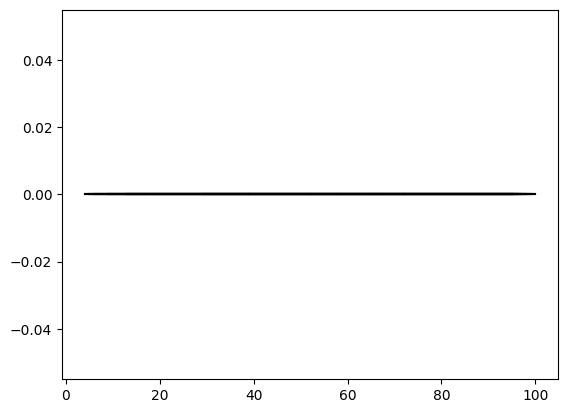

In [82]:
import matplotlib.pyplot as plt
import numpy as np
def plot_dendrogram_manual(linkage_matrix):
    """
    Trace un dendrogramme à partir d'une matrice de liens (linkage_matrix) de manière manuelle.
    
    Paramètres :
    - linkage_matrix : np.ndarray : la matrice de liens (Z) générée par un clustering hiérarchique.
    """
    # Calculer le nombre de clusters à partir de la matrice de liens
    n = linkage_matrix.shape[0]  # Le nombre de clusters initiaux
    
    # Créer un tableau pour les coordonnées des lignes
    x_vals = np.zeros((linkage_matrix.shape[0] * 2 + 1, 2))  # Tableau des coordonnées des clusters
    y_vals = np.zeros((linkage_matrix.shape[0] * 2 + 1, 2))  # Tableau des hauteurs
    
    # Dictionnaire pour garder une trace des indices des clusters
    cluster_indices = {i: i for i in range(n)}  # Chaque point commence avec son propre indice
    
    # Liste pour stocker les hauteurs des clusters pour chaque fusion
    heights = []
    
    # Identifier le prochain indice de cluster disponible
    next_cluster_idx = n
    
    for i, (cluster1, cluster2, dist, _) in enumerate(linkage_matrix):
        # Récupérer les indices des clusters à fusionner
        cluster1_idx = int(cluster1)
        cluster2_idx = int(cluster2)
        
        # Les nouvelles coordonnées pour le dendrogramme
        y_val = dist
        heights.append(y_val)
        
        # Mettez à jour les coordonnées X et Y pour le lien
        x_vals[i + n, 0] = cluster_indices[cluster1_idx]  # X pour le cluster 1
        x_vals[i + n, 1] = cluster_indices[cluster2_idx]  # X pour le cluster 2
        y_vals[i + n, 0] = y_val
        y_vals[i + n, 1] = y_val
        
        # Créer un nouveau cluster et lui assigner un nouvel index
        new_cluster_idx = next_cluster_idx
        next_cluster_idx += 1
        
        # Mise à jour de l'indice du nouveau cluster dans le dictionnaire
        cluster_indices[new_cluster_idx] = new_cluster_idx
        
        # Trace de la ligne entre les clusters
        plt.plot([cluster_indices[cluster1_idx], cluster_indices[cluster2_idx]], 
                 [y_val, y_val], color='black')  # ligne horizontale
        plt.plot([cluster_indices[cluster1_idx], new_cluster_idx], 
                 [y_val, y_val], color='black')  # ligne vers le nouveau cluster
        plt.plot([cluster_indices[cluster2_idx], new_cluster_idx], 
                 [y_val, y_val], color='black')  # ligne vers le nouveau cluster
        
        # Mise à jour des indices de clusters dans le dictionnaire
        cluster_indices[cluster1_idx] = new_cluster_idx
        cluster_indices[cluster2_idx] = new_cluster_idx

    # Configuration du tracé
    plt.title('Dendrogramme')
    plt.xlabel('Indice des clusters')
    plt.ylabel('Distance (hauteur)')
    
    # Ajuster l'échelle des axes
    plt.xticks(np.arange(n, n + len(linkage_matrix), 1))
    plt.show()

plot_dendrogram_manual(linkage_matrix)

In [68]:
clusters.key()

AttributeError: 'list' object has no attribute 'key'

In [47]:
data = sax.symbolized_x_train
num_samples = data.shape[0]
# Initialisation : chaque point est un cluster
clusters = []

for i in range(num_samples):
    clusters.append({
        'id': i,  # Identifiant unique du cluster
        'points': [data.iloc[i, :][0]],  # Liste des points dans le cluster
        'centroid': data.iloc[i, :][0]  # Centroïde initial = le point lui-même
    })

In [58]:
clusters

[{'id': 0,
  'points': ['mpigfcbbaabdhjlmlllm'],
  'centroid': 'mpigfcbbaabdhjlmlllm'},
 {'id': 1,
  'points': ['kgbbbabelnnnnllkmkfi'],
  'centroid': 'kgbbbabelnnnnllkmkfi'},
 {'id': 2,
  'points': ['lpkgfcbbaabeikmmmmlm'],
  'centroid': 'lpkgfcbbaabeikmmmmlm'},
 {'id': 3,
  'points': ['pnmkggdbaaabeikkjjjm'],
  'centroid': 'pnmkggdbaaabeikkjjjm'},
 {'id': 4,
  'points': ['pmmdcbaaafmnmlkkjjli'],
  'centroid': 'pmmdcbaaafmnmlkkjjli'},
 {'id': 5,
  'points': ['ohicbbaabfkmmlmlllmk'],
  'centroid': 'ohicbbaabfkmmlmlllmk'},
 {'id': 6,
  'points': ['pphgeddcbaabeiklllll'],
  'centroid': 'pphgeddcbaabeiklllll'},
 {'id': 7,
  'points': ['ophgecbaabejklklmllj'],
  'centroid': 'ophgecbaabejklklmllj'},
 {'id': 8,
  'points': ['pggdbbaabhmnmmmllkmj'],
  'centroid': 'pggdbbaabhmnmmmllkmj'},
 {'id': 9,
  'points': ['pnmdcbaabhmlllkkjiji'],
  'centroid': 'pnmdcbaabhmlllkkjiji'},
 {'id': 10,
  'points': ['ooijfecaaachlmllklnj'],
  'centroid': 'ooijfecaaachlmllklnj'},
 {'id': 11,
  'points': ['mpjhd

In [51]:
if sax.method == "TSAX":
    dist = TRENDIST(sax.alphabet_size, sax.train_ts_length, sax.angle_breakpoint_alphabet_size)
else: 
    dist = MINDIST(sax.alphabet_size, sax.train_ts_length)

num_clusters = len(clusters)
distance_matrix = np.full((num_clusters, num_clusters), np.inf)

for i in range(num_clusters):
    for j in range(i + 1, num_clusters):
        # Calculer la distance entre les centroïdes des clusters i et j
        if sax.method == "TSAX":
            d = dist.tsax_mindist(clusters[i]['centroid'], clusters[j]['centroid'])
        else: 
            d = dist.mindist(clusters[i]['centroid'], clusters[j]['centroid'])

        distance_matrix[i, j] = d
        distance_matrix[j, i] = d

distance_matrix

array([[        inf, 10.79707948,  0.35528956, ...,  3.90599569,
         6.60308673,  7.46232768],
       [10.79707948,         inf, 10.79837422, ...,  8.09804139,
         7.19328431,  5.74004527],
       [ 0.35528956, 10.79837422,         inf, ...,  3.7350633 ,
         6.44214886,  7.46044122],
       ...,
       [ 3.90599569,  8.09804139,  3.7350633 , ...,         inf,
         3.23821221,  3.44336872],
       [ 6.60308673,  7.19328431,  6.44214886, ...,  3.23821221,
                inf,  1.99038946],
       [ 7.46232768,  5.74004527,  7.46044122, ...,  3.44336872,
         1.99038946,         inf]])

In [52]:
np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

(4, 58)